# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import time
from dqn_agent import Agent
from collections import deque
import torch
import matplotlib.pyplot as plt
import pandas as pd

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
env

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [35]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = int(agent.act(state, 0.))
    #action = np.random.randint(action_size)        # select an action
    env_info = env.step(int(action))[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 18.0


When finished, you can close the environment.

In [7]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

#### Approach

I am taking the following approach:

* Overall we use a deep Q network (DQN) to train the agent using reinforcement learning.

* start with a simple DQN network and see if it is sufficient to solve the problem. The initial network I tried was a fully connected nn with sizes at each layer: start_size (input) -> 64 -> 128 -> action_size (out). But this model does not seem to be sufficiently rich. The score I got was moving around 10 while I think we should be able to move even higher.

* Then I tried a few other network structure. In the end I converge to the one I am submitting which is sufficient to get to score of ~15. The network is state_size -> 64 -> 128 -> 128 -> 64 -> action_size.

* Epsilon greedy algorithm is used, with esp started at 100%, decaying at 99.5% and floored at 1%.

* Replay buffer is used. We store upt o 10,000 memory and from that we randomly select experiences of batch size 64

* separately I have also tried to implement the following features to improve training:
  * [Double DQN](https://arxiv.org/abs/1509.06461) where use the latest Q net to pick the best next action, but use the target Q net to evaluate the action. This is controlled by the ddqn parameter when initializing the agent.
  * [Dueling](https://arxiv.org/abs/1511.06581) where we bifurcate the last layers of the network to separately predie the value function and the action specific adjustment on top. For the dueling we normalized the action output by the mean across actions. This is controlled by the dueling parameter when we initialize the agent.
  * [Prioried Experience Replay](https://arxiv.org/abs/1511.05952) where we prioritize the experience of higher TD difference. I also implemented the importance sampling weights as well. But the current implementation is extremely slow and more work is needed to make it useful. For now this feature is not used.
  
* I tried different combinations of training methods, ie, with and with out DDQN and Dueling respectively. This gives me 4 combinations. I ran these 4 models 10x each and plot out the resulting scores. To my surprise there is no observable pick up in the training speed across these few methodologies. it's possible that the network I used is too simple to observe material differences.


In [6]:
def dqn(agent, n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, filename=""):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        filename (string): filename to save the model parameters
    """
    high_score = -100
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    times = deque(maxlen=100)
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        time1 = time.time()
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(int(action))[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        time2 = time.time()
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        times.append(time2-time1)
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}\tAverage Time: {:.2f}\tBest Score Saved: {:.2f}'.format(i_episode, np.mean(scores_window), np.mean(times),high_score), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tAverage Time: {:.2f}\tBest Score Saved: {:.2f}'.format(i_episode, np.mean(scores_window), np.mean(times),high_score))
        mean_score = np.mean(scores_window)
        if mean_score>=high_score and mean_score > 10:
            torch.save(agent.qnetwork_local.state_dict(), filename)
            high_score = mean_score
            
    return scores

##### Model 1: Double DQN with Dueling

In [7]:
# Double DQN with Dueling
dddqn_scores = []

for i in range(10):
    print("\n\nAgent {:03d}:\n".format(i))
    agent = Agent(state_size=state_size, action_size=action_size, seed=i*100, ddqn=True, sampling_mode="Uniform", dueling=True )
    scores = dqn(agent, filename = "dddqn{:03d}.pth".format(i))
    dddqn_scores.append(scores)



Agent 000:

Episode 100	Average Score: 0.63	Average Time: 1.14	Best Score Saved: -100.00
Episode 200	Average Score: 3.29	Average Time: 1.15	Best Score Saved: -100.00
Episode 300	Average Score: 7.01	Average Time: 1.16	Best Score Saved: -100.00
Episode 400	Average Score: 10.67	Average Time: 1.17	Best Score Saved: 10.7700
Episode 500	Average Score: 13.48	Average Time: 1.16	Best Score Saved: 13.51
Episode 600	Average Score: 14.24	Average Time: 1.16	Best Score Saved: 14.30
Episode 700	Average Score: 15.28	Average Time: 1.15	Best Score Saved: 15.30
Episode 800	Average Score: 14.40	Average Time: 1.15	Best Score Saved: 15.55
Episode 900	Average Score: 15.44	Average Time: 1.14	Best Score Saved: 15.55
Episode 1000	Average Score: 14.90	Average Time: 1.15	Best Score Saved: 15.78


Agent 001:

Episode 100	Average Score: 0.44	Average Time: 1.11	Best Score Saved: -100.00
Episode 200	Average Score: 3.66	Average Time: 1.13	Best Score Saved: -100.00
Episode 300	Average Score: 7.35	Average Time: 1.13	B

##### Model 2: Double DQN (no Dueling)

In [10]:
# Double DQN
ddqn_scores = []

for i in range(10):
    print("\n\nAgent {:03d}:\n".format(i))
    agent = Agent(state_size=state_size, action_size=action_size, seed=i*100, ddqn=True, sampling_mode="Uniform", dueling=False )
    scores = dqn(agent, filename = "ddqn{:03d}.pth".format(i))
    ddqn_scores.append(scores)



Agent 000:

Episode 100	Average Score: 0.26	Average Time: 0.99	Best Score Saved: -100.00
Episode 200	Average Score: 2.39	Average Time: 1.00	Best Score Saved: -100.00
Episode 300	Average Score: 7.04	Average Time: 1.01	Best Score Saved: -100.00
Episode 400	Average Score: 10.12	Average Time: 1.02	Best Score Saved: 10.1600
Episode 500	Average Score: 12.52	Average Time: 1.02	Best Score Saved: 12.48
Episode 600	Average Score: 14.19	Average Time: 1.02	Best Score Saved: 14.19
Episode 700	Average Score: 15.56	Average Time: 1.02	Best Score Saved: 15.61
Episode 800	Average Score: 15.34	Average Time: 1.02	Best Score Saved: 16.13
Episode 900	Average Score: 15.12	Average Time: 1.02	Best Score Saved: 16.13
Episode 1000	Average Score: 15.41	Average Time: 1.02	Best Score Saved: 16.13


Agent 001:

Episode 100	Average Score: 0.72	Average Time: 0.99	Best Score Saved: -100.00
Episode 200	Average Score: 4.81	Average Time: 1.00	Best Score Saved: -100.00
Episode 300	Average Score: 8.27	Average Time: 1.01	B

##### Model 3: DQN (no double DQN or dueling)

In [11]:
# DQN
dqn_scores = []

for i in range(10):
    print("\n\nAgent {:03d}:\n\n".format(i))
    agent = Agent(state_size=state_size, action_size=action_size, seed=i*100, ddqn=False, sampling_mode="Uniform", dueling=False )
    scores = dqn(agent, filename = "dqn{:03d}.pth".format(i))
    dqn_scores.append(scores)



Agent 000:


Episode 100	Average Score: 0.80	Average Time: 0.98	Best Score Saved: -100.00
Episode 200	Average Score: 3.86	Average Time: 0.99	Best Score Saved: -100.00
Episode 300	Average Score: 6.92	Average Time: 1.00	Best Score Saved: -100.00
Episode 400	Average Score: 10.42	Average Time: 1.01	Best Score Saved: 10.4800
Episode 500	Average Score: 12.86	Average Time: 1.01	Best Score Saved: 12.74
Episode 600	Average Score: 15.36	Average Time: 1.01	Best Score Saved: 15.35
Episode 700	Average Score: 14.43	Average Time: 1.01	Best Score Saved: 15.41
Episode 800	Average Score: 15.39	Average Time: 1.01	Best Score Saved: 15.69
Episode 900	Average Score: 15.89	Average Time: 1.01	Best Score Saved: 16.01
Episode 1000	Average Score: 14.62	Average Time: 1.01	Best Score Saved: 16.05


Agent 001:


Episode 100	Average Score: 0.72	Average Time: 0.98	Best Score Saved: -100.00
Episode 200	Average Score: 3.98	Average Time: 0.99	Best Score Saved: -100.00
Episode 300	Average Score: 6.91	Average Time: 1.00

##### Model 4: DQN with Dueling (no Double DQN)

In [9]:
# Dueling
dueling_scores = []

for i in range(10):
    print("\n\nAgent {:03d}:\n\n".format(i))
    agent = Agent(state_size=state_size, action_size=action_size, seed=i*100, ddqn=False, sampling_mode="Uniform", dueling=True )
    scores = dqn(agent, filename = "dueling{:03d}.pth".format(i))
    dueling_scores.append(scores)



Agent 000:


Episode 100	Average Score: 0.97	Average Time: 1.09	Best Score Saved: -100.00
Episode 200	Average Score: 4.28	Average Time: 1.09	Best Score Saved: -100.00
Episode 300	Average Score: 7.40	Average Time: 1.12	Best Score Saved: -100.00
Episode 400	Average Score: 11.44	Average Time: 1.12	Best Score Saved: 11.2800
Episode 500	Average Score: 13.93	Average Time: 1.11	Best Score Saved: 14.19
Episode 600	Average Score: 15.57	Average Time: 1.11	Best Score Saved: 15.53
Episode 700	Average Score: 14.84	Average Time: 1.11	Best Score Saved: 15.71
Episode 800	Average Score: 13.83	Average Time: 1.11	Best Score Saved: 15.71
Episode 900	Average Score: 13.81	Average Time: 1.12	Best Score Saved: 15.71
Episode 1000	Average Score: 14.64	Average Time: 1.12	Best Score Saved: 15.71


Agent 001:


Episode 100	Average Score: 0.23	Average Time: 1.10	Best Score Saved: -100.00
Episode 200	Average Score: 3.08	Average Time: 1.11	Best Score Saved: -100.00
Episode 300	Average Score: 6.02	Average Time: 1.11

#### Evaluation of different training approaches

We plot out the training scores across different training approaches below (averaged over 10 trainings with different initial seed). We do not notice any significant differenes across methodogies, and they can all solve the problem (score = 13) at around 500 episodes.

In [12]:
def plot_scores(scores, label, rolling_window=100):
    scores = np.array(scores).mean(0)
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean, label = label);
    plt.legend()
    plt.xlabel('#episodes')
    plt.ylabel('Avg score')
    #plt.title(label);

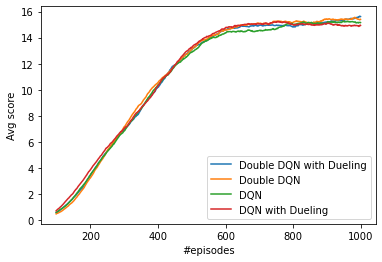

In [15]:
plot_scores(dddqn_scores, "Double DQN with Dueling")
plot_scores(ddqn_scores, "Double DQN")
plot_scores(dqn_scores, "DQN")
plot_scores(dueling_scores, "DQN with Dueling")

#### Check out the smart agent

In [14]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = int(agent.act(state, 0.))
    #action = np.random.randint(action_size)        # select an action
    env_info = env.step(int(action))[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 13.0


#### Next Steps

We can try a few things to further improve the agent:
* fix the prioritized experience replay data structure and sampling logic to make it faster. We can reference the methodolgy [here](https://nn.labml.ai/rl/dqn/replay_buffer.html) and [here](https://github.com/facebookresearch/ReAgent/tree/main/reagent/replay_memory)
* We can go one step further and try to implement the Rainbow model [here](https://paperswithcode.com/method/rainbow-dqn).
* We can spend more time on finetuning hyper parameters. For the above runs, I basically juse used the same parameters I used in the exercise. It seems to work but we can definitely improve by more fine-tuning.
* We can try more complicated network structure, eg, more layers, more nodes, try CNN or other structure.